In [1]:
# Import namespaces
import sys
import os
import math
import itertools
import json
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import scipy.linalg as la
import pandapower as pp
import pandas as pd

from scipy.stats import norm
from scipy.stats import uniform
from scipy.stats import multinomial
from scipy.linalg import pinvh
from pandapower import networks

from tqdm.notebook import tqdm, trange
import time 

In [2]:
# load matrices from file

grid4 = pp.networks.case4gs();
grid6 = pp.networks.case6ww();
grid14 = pp.networks.case14(); # ok
grid30 = pp.networks.case_ieee30();# ok
grid57 = pp.networks.case57(); 
grid118 = pp.networks.case118(); #? slack angle != 0
grid118i = pp.networks.iceland(); #ok
grid145 = pp.networks.case145();
grid200 = pp.networks.case_illinois200();# ok
grid300 = pp.networks.case300();
grid1354 = pp.networks.case1354pegase();
grid1888 = pp.networks.case1888rte(); # ok #slack angle != 0
grid2224 = pp.networks.GBnetwork(); # extremely high prob
grid2848 = pp.networks.case2848rte();
grid2869 = pp.networks.case2869pegase(); # high prob!
grid3120 = pp.networks.case3120sp(); #ok # feasibility check do not pass, check why
grid6470 = pp.networks.case6470rte(); #? slack angle != 0
grid6495 = pp.networks.case6495rte(); # multiple stacks
grid6515 = pp.networks.case6515rte(); #? slack angle != 0
grid9241 = pp.networks.case9241pegase(); # extremely high probability

net = grid118i

pp.rundcpp(net);
ppc = net["_ppc"];

In [3]:
##### Setup Grid fluctuation parameters and constraints ########


## thresold on shift significance in DC-PF Eqs
## pwr = pwr_shf + np.real(bbus)*va
##

shf_eps = 1e-4; 

## Std for fluctuating loads divided by their nominal values: 
## for small grids values 0.5-1 are realistic
## larger grids have cov_std = 0.1 -- 0.3 or less
##

cov_std = 0.1

## Phase angle difference limit
## small grids: pi/8 -- pi/6
## large grids: pi/3 -- pi/4
##

bnd = math.pi/4;

### Cut small probabilities threshold
### discard all probabilities than thrs* prb(closest hyperplane)
### 
###
### Crucially affects time performance
###

thrs = 0.001

### Number of samples used in experiments
### 500 is often enough
### 10000 is a default value supresses the variance

#nsmp = 10000; 
nsmp = 1000; 


### Step-sizes for KL and Var minimization 
### works well with 0.1-0.01

eta_vm = 0.1; 
eta_kl = 0.1; 

### Rounding threshold in optimization: 
### if a (normalized on the simplex) hpl probability becomes lower then 0.001
### we increase it to this level
###
### Crucially affects numerical stability
###

eps = 0.001

In [4]:
##### Setup power grid case in a convenient form for further sampling ########

### find number of lines (m) and buses(n)

m = net.line['to_bus'].size; 
n = net.res_bus['p_mw'].size;

### Construct adjacency matrix 
###

adj = np.zeros((2*m, n));
for i in range(0, m):
    adj[i, net.line['to_bus'][i]] = 1;
    adj[i, net.line['from_bus'][i]] = -1;
    adj[i+m, net.line['to_bus'][i]] = -1;
    adj[i+m, net.line['from_bus'][i]] = 1;
    
### DC power flow equations have a form: 
###
### pwr = pwr_shf + np.real(bbus)*va
### (compute all parameters)

bbus = np.real(ppc['internal']['Bbus']);
va = math.pi*net.res_bus['va_degree']/180;
pwr = - net.res_bus['p_mw'];
pwr_shf =  pwr - bbus@va;

### pwr_shf is significant or not:
###
### if the shift is small: zero it out
### (simplifies testing and removes "math zeros")

print("significant shift: ", np.max(pwr_shf) - np.min(pwr_shf) > shf_eps)
if (np.max(pwr_shf) - np.min(pwr_shf) < shf_eps):
    pwr_shf[range(0,n)] = 0
    

### Phase angle differences:
###
### va = pinv(bbus)*(pwr - pwr_shf)
### va_d = adj*va = adj*pinv(bbus)*(pwr - pwr_shf) 
### va_d = pf_mat*pwr - va_shf

bbus_pinv = pinvh(bbus.todense())
pf_mat = adj@bbus_pinv;
va_shf = pf_mat@pwr_shf;


### Voltage angle differences:
###

va_d = pf_mat@pwr - va_shf;

significant shift:  False


In [5]:
##### Distribution of fluctuations ######

### assume the only one slack (a higher-level grid) in the grid
### supress all its fluctuations and balance the grid
###
### TODO: adjust to a general case
### 

slck = net.ext_grid['bus'];  
slck_mat = np.eye(n);
slck_mat[slck] = -1; ## assign values to the whole array
slck_mat[slck,slck] = 0; # and zero out for the slack itself


### set fluctuating components: either loads or gens or both
###

loads = np.zeros(n);
gens = np.zeros(n);
ctrls = np.zeros(n); ## controllable loads + gens

loads[net.load['bus']] = - net.res_load['p_mw']; 
gens[net.gen['bus']] = net.res_gen['p_mw'];
ctrls = loads + gens;

### assume only loads are fluctuating
###

xi = loads;


### Set covariance matrix and mean
###
### cov_sq = square of the covariance matrix
### Gaussian rv with covariance \Sigma is \Sigma^{1/2} * std_normal_rv
###
### TODO: change to LU/cholesky factorization
### 

cov_sq = cov_std*np.diag(np.abs(xi));



### Final equations with fluctuations xi are then 
###
### w/o fluctuations: 
### va_d = pf_mat*pwr - va_shf
### with fluctuations:
### va_d = pf_mat@(pwr + slck_mat*cov_sq*xi) - va_shf
### va_d = pf_mat@pwr - va_shf + (pf_mat@(slck_mat@cov_sq))@xi_std 
### va_d = mu + A@xi_std
### where xi_std is a standard normal with only fluctuating components
###

A = (pf_mat@slck_mat)@cov_sq;
mu = pf_mat@pwr - va_shf; 

### Feasibility Polytope Inequalities
### bnd \ge va_d = mu_f + A_f@xi_std
### incorporates both va_d \le b and va_d \ge -b as we have va_d's with 2 signs
###
 
b = np.ones(2*m)*bnd; 

### normalize the matrices to make it easier to compute a failure probability
###

### compute row norms of A
nrms = np.maximum(la.norm(A, axis = 1), 1e-20)

### normalize A and b so that b_n\ge A_n*xi_std
b_n = (b-mu)/nrms;
A_n = [A[i]/nrms[i] for i in range(0, 2*m)]


In [6]:
##### Assest equations feasibility #######

### Power balance check 
###

print("Eqs balance check:", 0 == np.sum(np.sign(mu)))


### check positiveness of bnd - mu_f = RHS - LHS
###

print("Inqs. feasibility check: ", np.min(b - mu) > 0)
print("Min gap in phase angles = min(RHS - LHS)", np.min(b - mu)) ## positive value, otherwise the grid fails whp
print("The RHS (phase angle diff max) = ", bnd);


Eqs balance check: True
Inqs. feasibility check:  True
Min gap in phase angles = min(RHS - LHS) 0.4493208745964767
The RHS (phase angle diff max) =  0.7853981633974483


In [7]:
### Compute probabilities:
### prb: probability of each hpl failure 
### p_up, p_dwn: upper and lower bounds
###

prb = norm.cdf(-b_n);
p_up = np.sum(prb);
p_dwn = np.max(prb);

print("the union bound (upper):", p_up)
print("the max bound (lower):", p_dwn)

### Keep only valuable probabilities: 
### - use the union bound for all the rest
### - keep only the prbs higher than the thrs* p_dwn

prbh_id = (prb>thrs*p_dwn)
prb_rmd = np.sum(prb[~(prb>thrs*p_dwn)])

print("Remainder probability (omitted):", prb_rmd)


the union bound (upper): 0.0312790735177619
the max bound (lower): 0.007692552500548496
Remainder probability (omitted): 1.3706867957810815e-05


In [9]:
############ Preliminary steps for Sampling and Importance Sampling ############

### normalize all active probabilities to one 
### as we only play a hyperplane out of them
###
### NB: crucial steps in performance optimization
###

x_id = np.where(prbh_id == True)[0]

### local normalized versions of A and b, 
### reduced in size: number of rows now is equal to a number of constraints
### that have a high probability of violation
###

x_bn = b_n[x_id]

### we do not care about the full matrix A and vector b
### only about important parts of them
A_n = np.array(A_n)
x_An = A_n[x_id]

print("# hpls we care of: ", len(x_bn))

# hpls we care of:  15


In [9]:
############# Monte-Carlo ##################

rv = norm(); 
x_std = norm.rvs(size=[n,nsmp])
smp = x_An@x_std

### fls_mc = failures in Monte-Carlo, e.g. 
### when MC discovers a failure
###

fls_mc = sum((x_bn <= smp.T[:]).T); 
print("Max # of hlps a sample if out of: ", np.max(fls_mc))

### MC failure expectation and std
###

mc_exp = (1 - np.sum(fls_mc == 0)/nsmp)*(1 - prb_rmd)+prb_rmd;
mc_std = (1 - prb_rmd)/math.sqrt(nsmp);
# violation_dict = {}
for i in range(0,np.max(fls_mc)+1):
    print(i, "hpls violated (exactly) vs # cases",  np.sum(fls_mc == i))
#     violation_dict[i] = int(np.sum(fls_mc == i))

print("\nMC(exp, std):", (mc_exp, mc_std)); 

### write into file
# path_to_viol_dirs = os.path.join("results", "hplns_violations")
# with open(os.path.join(path_to_viol_dirs, "grid3120", "result.json"), 'w+') as fp:
#     json.dump(violation_dict, fp)

Max # of hlps a sample if out of:  7
0 hpls violated (exactly) vs # cases 990
1 hpls violated (exactly) vs # cases 6
2 hpls violated (exactly) vs # cases 3
3 hpls violated (exactly) vs # cases 0
4 hpls violated (exactly) vs # cases 0
5 hpls violated (exactly) vs # cases 0
6 hpls violated (exactly) vs # cases 0
7 hpls violated (exactly) vs # cases 1

MC(exp, std): (0.01001356979927824, 0.03162234315246046)


In [10]:
############# ALOE ##################
### 
### Exactly follows to the Owen/Maximov/Chertkov paper, EJOS'19
###
### sample z ~ N(0, I_n)
### sample u ~ U(0,1)
### compute y = F^{-1}(u F(-b_i))
### compute x = - (a_i * y + (I - a_i.T * a_i) z)
###
### Ouput: union bound divided by the expected failure multiplicity
###


### Initialize samplers
###
### sample z ~ N(0, I_n) and u ~ U(0,1)
### 

rv = norm();
rv_u = uniform();
z = norm.rvs(size=[nsmp,n]); 
u = uniform.rvs(size=[nsmp]);


### x_alph is a vector of ALOE probabilities 
### normalized by a unit simplex
###

x_alph = prb[prbh_id]/np.sum(prb[prbh_id]);
print("ALOE prbs for major hpls: ", x_alph)

### _hpl: how many smpls beyond each of the hpls
###

_hpl = multinomial.rvs(n = nsmp, p = x_alph);

### print("# samples per hpl", _hpl)

### Get cummulative sums, which are easier to work with
_hpl = list(itertools.accumulate(_hpl))
_hpl = np.array(_hpl)

### print("cusum of # hpls", _hpl)

### Generate samples
### x_aloe -- samples generated by ALOE
###
### TODO: seems optimizable, but I am not sure about memory mgmnt in python
x_aloe = np.zeros([nsmp, n]); 

# index of the active hyperplane
hpl_id = 0;

### get samples x_aloe according to the algorithm
#for i in tqdm(range(0,nsmp)):
for i in range(0,nsmp):
    ### get index of a hyperplane to sample beyond
    hpl_id = (hpl_id, hpl_id+1)[i >= _hpl[hpl_id]];
    y = norm.ppf(u[i]*norm.cdf(-x_bn[hpl_id]));
    x_aloe[i] = - x_An[hpl_id]*y - z[i] + np.outer(x_An[hpl_id],x_An[hpl_id])@z[i];

### test how many constraints are violated
smp = x_An@x_aloe.T

### compute expectation and std final and history
aloe_exp = p_up*np.sum(1./np.sum(x_bn <= smp.T[:],axis=1))/nsmp + prb_rmd; 
aloe_std = p_up*math.sqrt(2*len(_hpl))/math.sqrt(nsmp); # indeed len(_hpl) instead of 2*m in the Thrm
aloe_exp_history = [p_up * np.sum(1. / np.sum(x_bn <= (x_An@x_aloe[:i, :].T).T, axis=1)) / (i + 1) + prb_rmd for i in range(0,nsmp)]
aloe_std_history = [p_up*math.sqrt(2*len(_hpl))/math.sqrt(i + 1) for i in range(0, nsmp)]


print("ALOE (exp, std)", (aloe_exp, aloe_std))

ALOE prbs for major hpls:  [0.00043828 0.00043828 0.05510954 0.00031233 0.00053445 0.07100662
 0.00299764 0.17805892 0.07662494 0.07662494 0.24604069 0.00206235
 0.13633282 0.07662494 0.07679323]


c:\users\aleks\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


ALOE (exp, std) (0.01101811936308308, 0.005417694454644579)


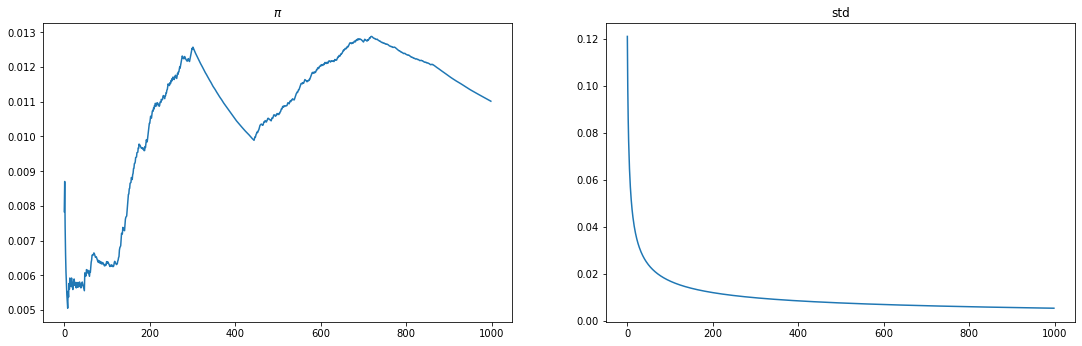

In [11]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(aloe_exp_history[1:])
ax2.set_title('std')
ax2.plot(aloe_std_history[1:])


In [12]:
####### Optimization approach ######
#######
####### Variance Minimization ######
####### 


### setup the initial values

eta = eta_vm; 
md_var = 0; 
md_exp = 0;
grad = np.zeros(len(x_bn)); #gradient on each iteration
_hpl = np.zeros(nsmp); # hpls choosen by the method 

### intentionally use a copy instead of a reference
### alph is a vector of weigths to be updated in algorithm
###

alph = x_alph[:];

### history of probability estimate and std
md_exp_history = []
md_std_history = []

# values for Phi (x_bn)
x_phi = [norm.cdf(-x_bn[i]) for i in range(0, len(x_bn))]

### grad normalization by prbs[i] factor is introduced to make computations numerically stable
###

prbs = prb[prbh_id];

for i in tqdm(range(0,nsmp)):
    
    ### sample x according to current alph
    hpl_id = np.where(multinomial.rvs(n=1,p = alph, size=1, random_state=None)[0] == 1)[0];
    _hpl[i] = hpl_id;        
    
    ### generate a sample following to the ALOE procedure
    y = norm.ppf(u[i]*norm.cdf(-x_bn[hpl_id]));
    
    x_smp = - x_An[hpl_id]*y - z[i] + np.outer(x_An[hpl_id],x_An[hpl_id])@z[i];
    
    ### the RHS' to be compared with x_bn
    x_smp = x_An@x_smp.T;

    ### results of constraints violations for each generated object
    cns_vlt = (x_bn <= x_smp.T[:])[0]
    
    ### weight vector defined by the multiplicity of constraint violation for each sample
    wgt = 1./np.sum(np.multiply(cns_vlt, np.multiply(alph, 1./x_alph))); 
    
    
    ### compute gradient of the variance, see the paper (our + OMC) for details
    grad = [-p_up*p_up*wgt*wgt*norm.pdf(x_smp[k])[0]*cns_vlt[k]/prbs[k] for k in range(len(x_smp))];
    grad = np.array(grad)

    
    ### The gradient is high -- signal about emergency as it can zero out all weights
    if (la.norm(eta*grad)>1e4):
        print("\n##############    Extremely high gradient      ############\n");
        print("Iteration: ", i, "\nGradient:", grad)
    
    ### make a ``simplex MD'' update
    alph = [math.exp(-eta*grad[k])*alph[k] for k in range(0,len(x_smp))];
    

    ### enter if some coordinates are too small and may cause numerical instability
    ### increase the corresponding weigths
    if (np.min(alph) < eps):
        print("###########  some coordinates are small  #################")
        alph = [alph[k]+eps for k in range(0,len(x_bn))];
        
    ### make a projection to the unit simplex
    alph = alph/np.sum(alph); 
    
    ### adjust contribution to the errors
    md_exp = md_exp + wgt;
    md_exp_history.append(p_up * md_exp / (i + 1) + prb_rmd)
    md_var = md_var + p_up*np.dot(grad.T,grad);
    md_std_history.append(p_up * math.sqrt(md_var) / (i + 1))
    
    
print("Optimal weigths of MD-Var minimization: ", alph)
print("Optimal weigths of ALOE", x_alph)

### normalize errors, compute standard deviation
md_exp = p_up*md_exp/nsmp + prb_rmd; 
md_std = p_up*math.sqrt(md_var)/nsmp;

print("MD-Var (exp, std)", (md_exp, md_std))
#print("assert normalization:", np.sum(alph), np.sum(x_alph))

  0%|          | 0/1000 [00:00<?, ?it/s]

###########  some coordinates are small  #################
Optimal weigths of MD-Var minimization:  [0.00140206 0.00140206 0.05479257 0.00127925 0.00149582 0.07040128
 0.00389748 0.17735026 0.07579623 0.07579623 0.24687638 0.00298586
 0.13476509 0.07579623 0.0759632 ]
Optimal weigths of ALOE [0.00043828 0.00043828 0.05510954 0.00031233 0.00053445 0.07100662
 0.00299764 0.17805892 0.07662494 0.07662494 0.24604069 0.00206235
 0.13633282 0.07662494 0.07679323]
MD-Var (exp, std) (0.01072966829529089, 1.5128954085517537e-07)


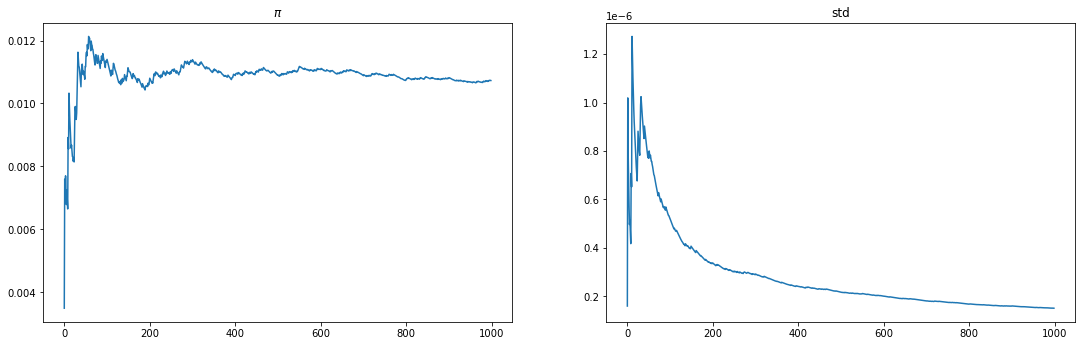

In [13]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(md_exp_history[1:])
ax2.set_title('std')
ax2.plot(md_std_history[1:])


In [14]:
####### Optimization approach ######
#######
####### KL Minimization ######
#######

### SMD step-size
eta = eta_kl; 

### setup initial values
kl_exp = 0; 
kl_var = 0; 
grad = np.zeros(len(x_bn));
_hpl = np.zeros(nsmp); ## _hpl[i] = beyond which hpl we sample on iteration i

### intentionally use a copy instead of a reference
### alph is an optimization variable
alph = x_alph[:];

### history of probability estimate and std
kl_exp_history = []
kl_std_history = []

### this normalization factor is introduced to make computations numerically stable
prbs = prb[prbh_id];


for i in tqdm(range(0,nsmp)):#,miniters=500):
    
    ### sample x according to current alph
    hpl_id = np.where(multinomial.rvs(n=1,p = alph, size=1, random_state=None)[0] == 1)[0];
    _hpl[i] = hpl_id;        
    
    ### generate a sample accordint to ALOE
    y = norm.ppf(u[i]*norm.cdf(-x_bn[hpl_id]));
    x_smp = - x_An[hpl_id]*y - z[i] + np.outer(x_An[hpl_id],x_An[hpl_id])@z[i];
    
    ### RHS to compare with x_bn
    x_smp = x_An@x_smp.T;
    
    ### results of constraints violations for the generated object
    cns_vlt = (x_bn <= x_smp.T[:])[0]
    
    ### object weight which is set according to ALOE
    wgt = 1./np.sum(np.multiply(cns_vlt, np.multiply(alph, 1./x_alph))); 
    
    # the KL divergence's gradient 
    grad = [-p_up*wgt*norm.pdf(x_smp[k])[0]*cns_vlt[k]/prbs[k] for k in range(len(x_smp))];
    grad = np.array(grad)

    ### The gradient is high -- signal about emergency as it can zero out all weights
    if (la.norm(eta*grad)>1e4):
        print("\n##############    Extremely high gradient      ############\n");
        print("Iteration: ", i, "\nGradient:", grad)
    
    ### make a ``simplex MD'' update
    alph = [math.exp(-eta*grad[k])*alph[k] for k in range(0,len(x_smp))];
    
    ### enter if some coordinates are too small and may cause numerical instability
    ### increase the corresponding weigths
    if (np.min(alph) < eps):
        print("###########  some coordinates are small  #################")
        alph = [alph[k]+eps for k in range(0,len(x_bn))];
        
    ### make a projection to the unit simplex
    alph = alph/np.sum(alph); 
    
    ### adjust contribution to the errors
    kl_exp = kl_exp + wgt;
    kl_exp_history.append(p_up * kl_exp / (i + 1) + prb_rmd)
    kl_var = kl_var + p_up*np.dot(grad.T,grad)*wgt;
    kl_std_history.append(p_up * math.sqrt(kl_var) / (i + 1))
    
print("Optimal weigths of MD-KL minimization: ", alph)
print("Optimal weigths of ALOE", x_alph)

### normalize errors
kl_exp = p_up*kl_exp/nsmp + prb_rmd; 
kl_std = p_up*math.sqrt(kl_var)/nsmp;
print("MD-KL (exp, std)", (kl_exp, kl_std))

#print("assert normalization:", np.sum(alph), np.sum(x_alph))

  0%|          | 0/1000 [00:00<?, ?it/s]

###########  some coordinates are small  #################
###########  some coordinates are small  #################
Optimal weigths of MD-KL minimization:  [0.00133929 0.00133929 0.03769592 0.00128109 0.00138856 0.05003733
 0.00261433 0.16980364 0.05804909 0.05804909 0.36823697 0.00216459
 0.13158051 0.05804909 0.05837122]
Optimal weigths of ALOE [0.00043828 0.00043828 0.05510954 0.00031233 0.00053445 0.07100662
 0.00299764 0.17805892 0.07662494 0.07662494 0.24604069 0.00206235
 0.13633282 0.07662494 0.07679323]
MD-KL (exp, std) (0.010008868586441457, 4.3255388106456884e-06)


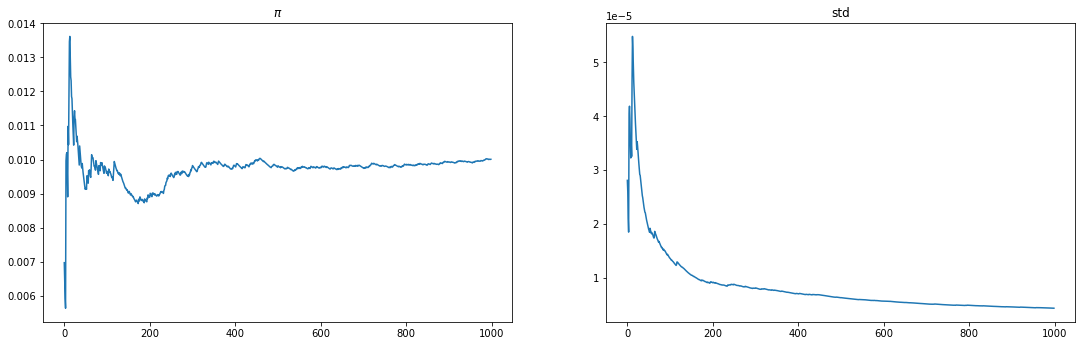

In [15]:

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title(r'$\pi$')
ax1.plot(kl_exp_history[1:])
ax2.set_title('std')
ax2.plot(kl_std_history[1:])


In [16]:
##############  Output all probabilities  ##################

print("the union bound (up):", p_up)
print("the max bound (lower):", p_dwn)

print("MC(exp, std):", mc_exp, mc_std); 
print("ALOE(exp, std)", aloe_exp, aloe_std)

print("MD-Var(exp, var)", md_exp, md_std)
print("MD-KL(exp, var)", kl_exp, kl_std)

the union bound (up): 0.0312790735177619
the max bound (lower): 0.007692552500548496
MC(exp, std): 0.01001356979927824 0.03162234315246046
ALOE(exp, std) 0.01101811936308308 0.005417694454644579
MD-Var(exp, var) 0.01072966829529089 1.5128954085517537e-07
MD-KL(exp, var) 0.010008868586441457 4.3255388106456884e-06


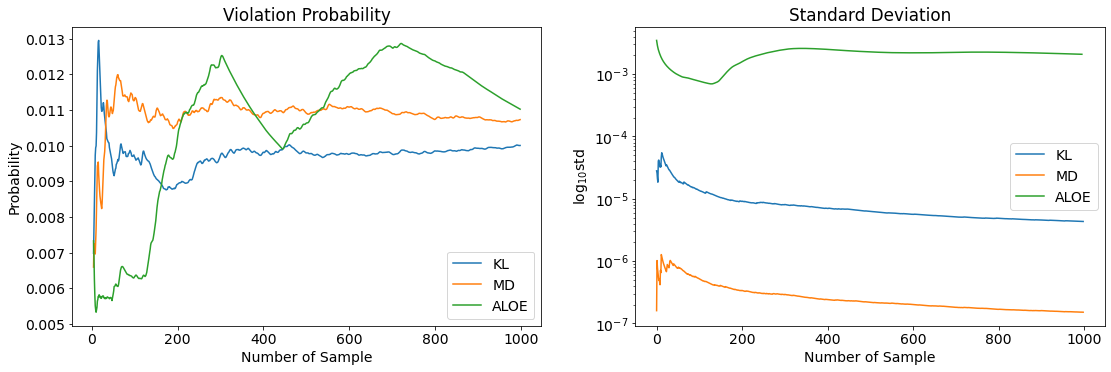

In [22]:
roll = 5
plt.rcParams['font.size'] = '14'
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5.5)
ax1.set_title('Violation Probability')
ax1.plot(pd.Series(kl_exp_history[1:]).rolling(roll).mean()[roll - 1:], label='KL')
ax1.plot(pd.Series(md_exp_history[1:]).rolling(roll).mean()[roll - 1:], label='MD')
ax1.plot(pd.Series(aloe_exp_history[1:]).rolling(roll).mean()[roll - 1:], label='ALOE')
#ax1.set_ylim(min(md_exp_history) - 1e-3, max(md_exp_history) + 1e-3)
ax1.set_xlabel('Number of Sample')
ax1.set_ylabel('Probability')
ax1.legend()
ax2.set_title('Standard Deviation')
ax2.semilogy(kl_std_history[1:], label='KL')
ax2.semilogy(md_std_history[1:], label='MD')
#ax2.semilogy(aloe_std_history[1:], label='ALOE')
ax2.semilogy([np.std(aloe_exp_history[:i]) for i in range(len(aloe_exp_history))][4:], label='ALOE')
ax2.set_xlabel('Number of Sample')
ax2.set_ylabel(r'$\log_{10}$std')
#ax2.set_ylim(-1e-7, 0.1)
ax2.legend()
#plt.savefig('118i_prob_std.jpg')

In [18]:
# # check what python distributions can do and how well

# print("--------------------\n Sanity check:\n")
# # cdf (x, mean, std)
# z = -12; 
# print("cdf/ppf: ", z == norm.ppf(norm.cdf(z,0,1), 0, 1));

# # test linear algebra 
# print("la/norm: ", la.norm(z) == -z);

# A = np.matrix([[4,0.5,0,0],[0.5,1,0,0],[0,0,1,0],[0,0,0,1.]])

# L = la.cholesky(A, lower = True)

# # A  = LL'
# print("la/cholesky: ", 0 == np.sum(A != L@L.T))

# B = np.matrix([[0,0,0],[0,5,0],[0,0,1]]);
# B_pnv = la.pinvh(B)
# print("la/pinv: ", 0 == np.sum(B != B@(B@B_pnv)))

In [19]:
## conditional sampling outside of a hyperplane
## a separate test for 1 dimensional case

# sample z ~ N(0, I_n) and u ~ U(0,1)
"""
d = 1;
_z = norm.rvs(size=[nsmp,d]); 
_u = uniform.rvs(size=[nsmp]);

x_test = np.zeros([nsmp, d]); 
thrs = 3;
a = np.array([1]);

for i in range(0,nsmp):
    ## get index of a hyperplane    
    y = norm.ppf(_u[i]*norm.cdf(-thrs));
    x_test[i] = - a*y - _z[i] + np.outer(a,a)@_z[i];

_ans = np.sort(x_test.T[0])
    
# check number of items falls into 3.5 +, 3.75+ and 4+
print(np.sum(_ans > 4)/nsmp, norm.cdf(-4)/norm.cdf(-3))
print(np.sum(_ans > 3.75)/nsmp, norm.cdf(-3.75)/norm.cdf(-3))
print(np.sum(_ans > 3.5)/nsmp, norm.cdf(-3.5)/norm.cdf(-3))

"""


'\nd = 1;\n_z = norm.rvs(size=[nsmp,d]); \n_u = uniform.rvs(size=[nsmp]);\n\nx_test = np.zeros([nsmp, d]); \nthrs = 3;\na = np.array([1]);\n\nfor i in range(0,nsmp):\n    ## get index of a hyperplane    \n    y = norm.ppf(_u[i]*norm.cdf(-thrs));\n    x_test[i] = - a*y - _z[i] + np.outer(a,a)@_z[i];\n\n_ans = np.sort(x_test.T[0])\n    \n# check number of items falls into 3.5 +, 3.75+ and 4+\nprint(np.sum(_ans > 4)/nsmp, norm.cdf(-4)/norm.cdf(-3))\nprint(np.sum(_ans > 3.75)/nsmp, norm.cdf(-3.75)/norm.cdf(-3))\nprint(np.sum(_ans > 3.5)/nsmp, norm.cdf(-3.5)/norm.cdf(-3))\n\n'